<a href="https://colab.research.google.com/github/kristinepetrosyan/Mod4project/blob/master/Mode4project_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importing necessary packages and dictionaries

# fundamentals
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%pylab inline
import seaborn as sns

# visualization libraries
from PIL import Image
from keras.utils import plot_model
from IPython.display import Image 

# preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modelling
import tensorflow.keras as keras 
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras.models import Sequential
#from keras.losses import binary_crossentropy
from keras.models import Sequential
#from keras.optimizers import SGD, Adam
#from keras.initializers import glorot_uniform
#from keras import losses
from keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.metrics import Precision, Recall
from keras.applications import Xception, VGG16
#from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

# callbacks
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics



import itertools 
import functools
import operator
import math 

# Surpress warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
new_dir = "./chest_xray"

In [5]:
import os
train_folder = os.path.join(new_dir, 'train')
test_folder = os.path.join(new_dir, 'test')
val_folder = os.path.join(new_dir, 'val')


In [6]:
train_filenames, val_filenames = train_test_split(train_folder, test_size=0.2)
print(train_folder)

./chest_xray/train


In [7]:
#We noticed that we only have 16 images for validation which doesn't make sense
# , so we will come back to this later and will create our own validation set.
# Get all the data in the directory chest_xrays/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size=624, 
        color_mode='grayscale')

# Get all the data in the directory chest_xrays/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_folder, 
        target_size=(224, 224), 
        batch_size=5216,
        color_mode='grayscale')




Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [8]:
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

(224, 224, 1)


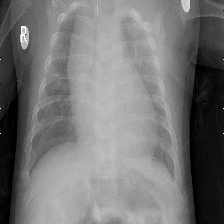

In [9]:
# print size and show image
print(train_images[10].shape)
array_to_img(train_images[10])

Let's take a look at the shape of the image. As we can see there is some slight distortion with the image being squished in the longitudal direction, however, our CNN should still be able to make out the important features.

In [12]:
#Let's investigate these images. We need to change them from 4D tensor to 2D matrix.
# check shape
print("Train Data Shape: {}".format(train_images.shape))
print("Test Data Shape: {}".format(test_images.shape))

Train Data Shape: (5216, 224, 224, 1)
Test Data Shape: (624, 224, 224, 1)


In [13]:
# change shape of train and test datasets
train_img_unrow = train_images.reshape(5216, -1).T
test_img_unrow = test_images.reshape(624, -1).T

In [14]:
# checking new changes
train_img_unrow.shape

(50176, 5216)

Let's normalize our pixel data by dividing by 255.0. It is important to normalize the data so that it facilitates convergence of the neural network

In [15]:
# we will create normalized pixel distributions
train_img_normalized = train_img_unrow / 255.00
test_img_normalized = test_img_unrow / 255.00

## Analyze the data

We will check our label data. We can confirm its shape is correct and investigate the labels. As we can see below we do not know which column of our train_labels matrix represents normal and pneumonia classification, however, we may find this data under class indices of the generator objects

In [16]:
# check out raw labels
train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Now we can select the 'PNEMONIA' column so that a pneumonia case is represented as a 1 and normal is represented as 0.

In [18]:
# train: transposing penumonia column...
train_labels_final = train_labels.T[[1]]
# same here
test_labels_final = test_labels.T[[1]]
print(test_labels_final)

[[1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
  1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
  1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.
  1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
  1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
  0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1.
  1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
  1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
  1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.
  1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 

In [19]:

# sum of people who have penumonia in the train set. 
train_pnemonia_cases = sum(train_labels_final[0])
print(train_pnemonia_cases)
# number of people who are healthy....
train_healthy_cases = len(train_labels_final[0]) - train_pnemonia_cases
print(train_healthy_cases)

test_pnemonia_cases = sum(test_labels_final[0])
test_healthy_cases = len(test_labels_final[0]) - test_pnemonia_cases

3875.0
1341.0


In [20]:
# print total number of cases
print("Total Pneumonia Cases in Train Set: {}".format(train_pnemonia_cases))
print("Total Healthy Cases in Train Set: {}".format(train_healthy_cases))
print("Total Pneumonia Cases in Test Set: {}".format(test_pnemonia_cases))
print("Total Healthy Cases in Test Set: {}".format(test_healthy_cases))

Total Pneumonia Cases in Train Set: 3875.0
Total Healthy Cases in Train Set: 1341.0
Total Pneumonia Cases in Test Set: 390.0
Total Healthy Cases in Test Set: 234.0


### Train data vizualization

Text(0, 0.5, 'Number of Cases')

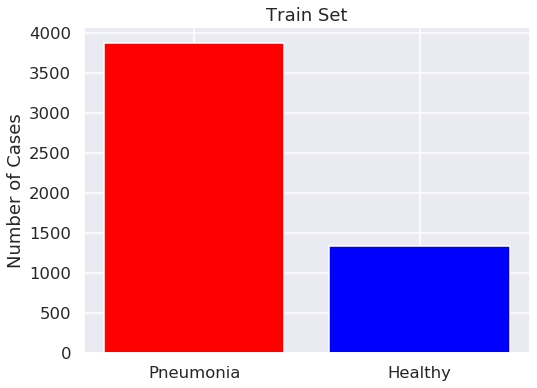

In [21]:
# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create barplot
plt.figure(figsize=(8,6))
plt.bar(x=['Pneumonia', 'Healthy'], height=[train_pnemonia_cases, train_healthy_cases], color=['red', 'blue'])
plt.title("Train Set")
plt.ylabel("Number of Cases")

### Test set visualization

Text(0, 0.5, 'Number of Cases')

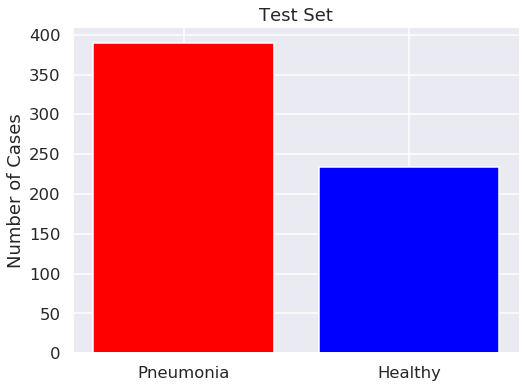

In [22]:
# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create barplot
plt.figure(figsize=(8,6))
plt.bar(x=['Pneumonia', 'Healthy'], height=[test_pnemonia_cases, test_healthy_cases], color=['red', 'blue'])
plt.title("Test Set")
plt.ylabel("Number of Cases")

# Baseline Convolutional Neural Network

For our image classification project we will use CNN(convolutional neural networks) to classify our x-ray images. We will first create a baseline model which will be used for further improvement. Our baseline model will be based on VGG16 (Visual Geometry Group from Oxford) model due to its relatively simple architecture and exceptional performance in the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) in 2014.

The general architecture will consist of stacking convolutional layers with 3x3 filters followed by max pooling layers. The pooling layers have the effect of making the output feature maps of the convolutional layers more robust to changes in the location of the feature in the image. A convolutional layer combined with a max pooling layer consists of one block. Blocks may be added with the convolutional layer in each block containing more filters and each block capable of detecting even higher order features of the images.

Our first model will contain only one block.

We will create a new ImageDataGenerator instance which will automatically load our image data in 64 image batches "as needed" and normalize them on the fly between zero and one.

Kaglle dataset only has 16 x-ray images for the validation set. This is very small relative to the training set and that is the reason that we are going to extract our own validation set from the training set.

In [23]:
# initialize data generator instance which will standardize on the fly as we did previusly
# use 10% of training data as validation set
generator = ImageDataGenerator(rescale=1.0/255.0,
                               validation_split=0.10)

In [24]:
# Get all the data in the directory chest_xrays/test and resize
test_gen = generator.flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=624, 
        color_mode='grayscale',
        shuffle=True)

# Get all the data in the directory chest_xrays/train and resize
train_gen = generator.flow_from_directory(
        train_folder, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=4695,
        color_mode='grayscale',
        subset='training')

# create a validation dataset
val_gen = generator.flow_from_directory(
        train_folder, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=521,
        color_mode='grayscale',
        subset='validation')

Found 624 images belonging to 2 classes.
Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


Now we will write a function to build our single block VGG inspired baseline model.

In [25]:
def create_model_VGG1(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # add one convolutional layer with 32 3x3 filters
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))

    # add max pooling layer
    model.add(MaxPooling2D())

    # add flattening layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [26]:
baseline_model = create_model_VGG1()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
baseline_model.trainable = False


In [28]:
# define path to save model and set callbacks for future training
model_path = './VGG_batch_norm_model.h5'

callbacks = [EarlyStopping(monitor='val_acuracy', 
                           patience=10,
                           #mode='max',
                           verbose=1),
             ModelCheckpoint(model_path,
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=0)]

In [29]:
# train model
history = baseline_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=20,
                              validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks)


Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[4695,224,224,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node conv2d_1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
# train model
history = baseline_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=30,
                              validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks)

In [ ]:
# check if GPU is running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
#I uninstalled torch using !pip uninstall torch then used the that line
#!curl -s https://course.fast.ai/setup/colab | bash
#and after I ran this torch.cuda.is_available()

Found GPU at: /device:GPU:0


In order to evaluate our model we will write a function to evaluate accuracy, precision, and recall vs. epochs. This will help us determine if we are overfitting, underfitting, or have a good balance between the two. This will also help us optimize our clssification threshold so we can maximize the recall.

In [ ]:
# define model evaluation
def model_evaluation(history, p_r_iteration=2):

    # set context for plots
    sns.set_style('darkgrid') 
    sns.set_context('talk') 
    
    # define number of epochs
    epochs = range(1, len(history.history['accuracy'])+1)
    
    # plot accuracy
    plt.figure(figsize=(15,8))
    pyplot.title("Accuracy") 
    ax = plt.plot(epochs, history.history['accuracy'], color='blue', label='Train Data') 
    ax = plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    # plot recall
    plt.figure(figsize=(15,8))
    pyplot.title("Precision") 
    plt.plot(epochs, history.history['recall_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_recall_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot precision
    plt.figure(figsize=(15,8))
    pyplot.title("Recall") 
    plt.plot(epochs, history.history['precision_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_precision_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    

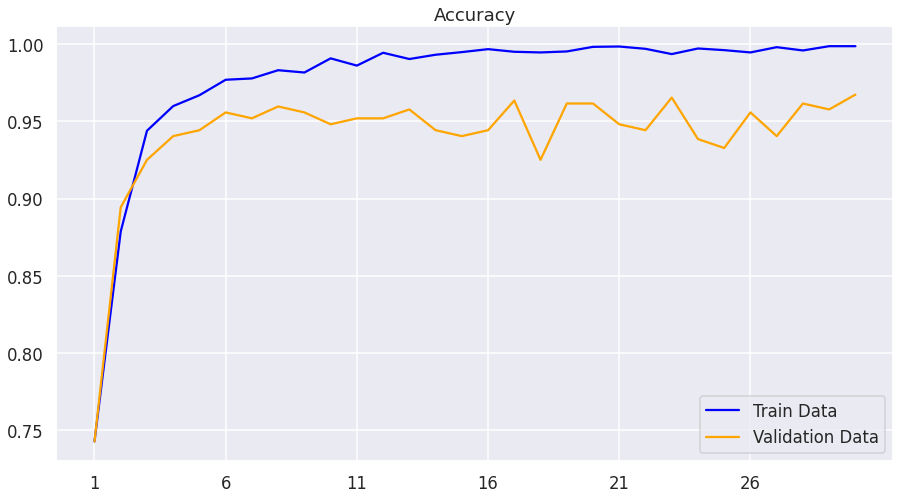

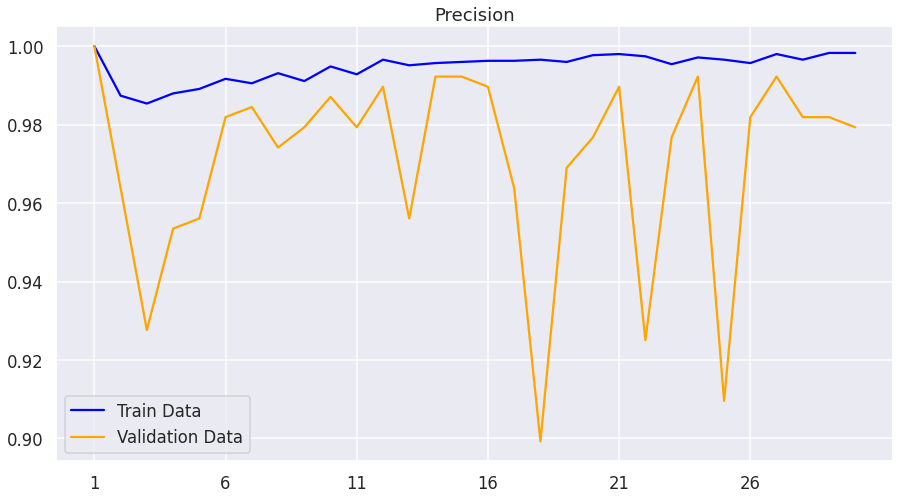

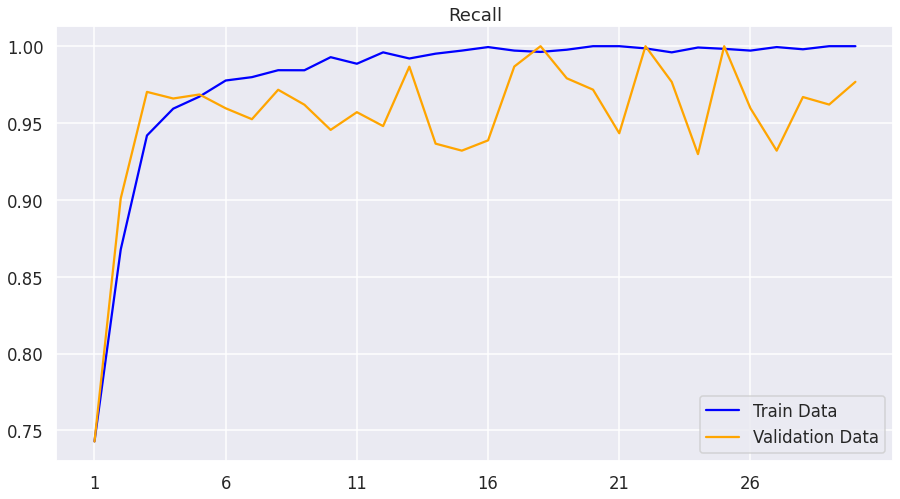

In [ ]:
# evaluate baseline model
model_evaluation(history, p_r_iteration=1)

In [ ]:
# evaluate on test set

baseline_model_test_accuracy = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
baseline_model_test_precision = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
baseline_model_test_recall = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(baseline_model_test_accuracy*100))
print("Test Set Precision: {}%".format(baseline_model_test_precision*100))
print("Test Set Recall: {}%".format(baseline_model_test_recall*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Set Accuracy: 71.79487347602844%
Test Set Precision: 68.97163391113281%
Test Set Recall: 99.74358677864075%


In [ ]:
# plot confusion matrix for test set
Y_pred_vgg1 = baseline_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg1 = np.where(Y_pred_vgg1>0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg1)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg1))

Confusion Matrix
[[ 59 175]
 [  1 389]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.25      0.40       234
           1       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.62      0.61       624
weighted avg       0.80      0.72      0.66       624



#Deeper CNN


##Three Block VGG Architecture

In [ ]:
def create_model_VGG_3(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [ ]:
# create model
VGG_3_model = create_model_VGG_3()

In [ ]:
# train model
hitory_VGG_3 = VGG_3_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=10,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10
74/74 [==============================] - 50s 675ms/step - loss: 0.4724 - accuracy: 0.9131 - precision_2: 0.9420 - recall_2: 0.9409 - val_loss: 0.1892 - val_accuracy: 0.9271 - val_precision_2: 0.9463 - val_recall_2: 0.9561
Epoch 2/10
74/74 [==============================] - 49s 662ms/step - loss: 0.0706 - accuracy: 0.9747 - precision_2: 0.9842 - recall_2: 0.9817 - val_loss: 0.1883 - val_accuracy: 0.9290 - val_precision_2: 0.9248 - val_recall_2: 0.9845
Epoch 3/10
74/74 [==============================] - 49s 656ms/step - loss: 0.0420 - accuracy: 0.9883 - precision_2: 0.9917 - recall_2: 0.9925 - val_loss: 0.1535 - val_accuracy: 0.9539 - val_precision_2: 0.9714 - val_recall_2: 0.9664
Epoch 4/10
74/74 [==============================] - 49s 664ms/step - loss: 0.0210 - accuracy: 0.9921 - precision_2: 0.9948 - recall_2: 0.9946 - val_loss: 0.2024 - val_accuracy: 0.9424 - val_precision_2: 0.9451 - val_recall_2: 0.9793
Epoch 5/10
74/74 [==============================] - 51s 687ms/step -

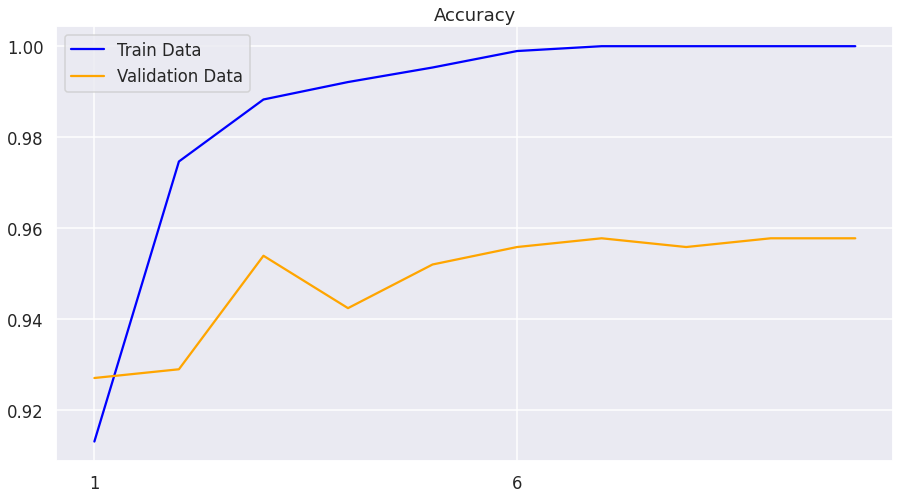

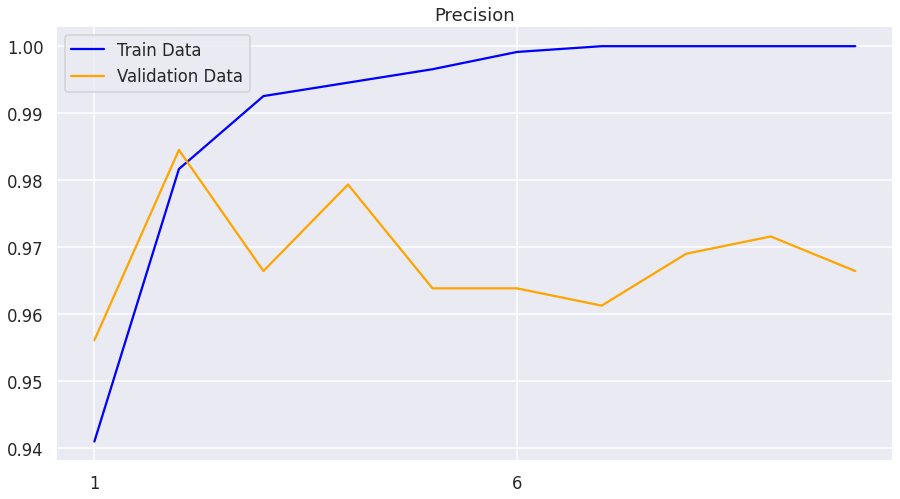

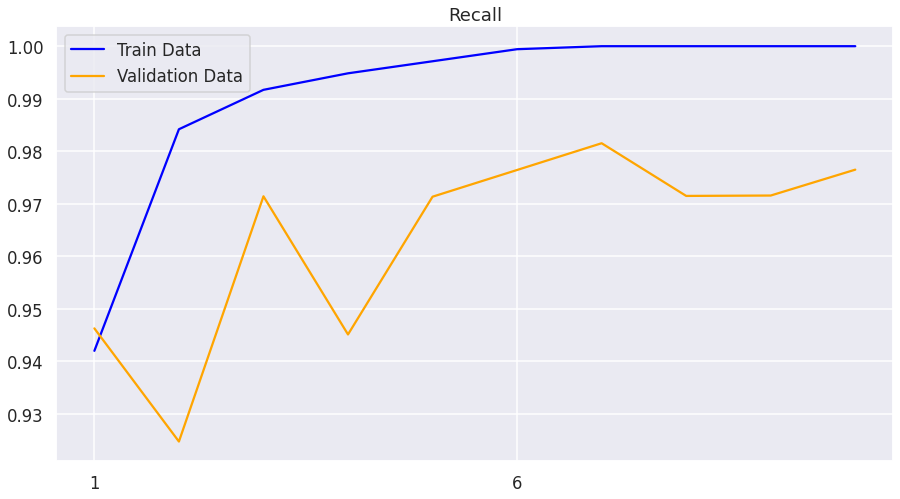

In [ ]:
# evaluate model
model_evaluation(hitory_VGG_3, p_r_iteration=2)


In [ ]:
# evaluate on test set

VGG_3_test_accuracy = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_test_precision = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_test_recall = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_test_recall*100))

Test Set Accuracy: 53.36538553237915%
Test Set Precision: 59.53757166862488%
Test Set Recall: 79.23076748847961%


In [ ]:
# plot confusion matrix for test set
Y_pred_vgg3 = VGG_3_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg3 = np.where(Y_pred_vgg3>0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg3)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg3))

Confusion Matrix
[[ 24 210]
 [ 81 309]]
Classification Report
              precision    recall  f1-score   support

           0       0.23      0.10      0.14       234
           1       0.60      0.79      0.68       390

    accuracy                           0.53       624
   macro avg       0.41      0.45      0.41       624
weighted avg       0.46      0.53      0.48       624



In [ ]:
# calculate specificity
print("Specificity: {}".format((102/(102+132))))

Specificity: 0.4358974358974359


## Five Block VGG Architecture

In [ ]:
def create_model_VGG_5(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block four
    model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block five
    model.add(Conv2D(512, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [ ]:
# create model
VGG_5_model = create_model_VGG_5()

In [ ]:
# train model
hitory_VGG_5 = VGG_5_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=10,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10
74/74 [==============================] - 50s 674ms/step - loss: 0.5894 - accuracy: 0.8590 - precision_4: 0.8903 - recall_4: 0.9240 - val_loss: 0.1798 - val_accuracy: 0.9251 - val_precision_4: 0.9833 - val_recall_4: 0.9147
Epoch 2/10
74/74 [==============================] - 49s 665ms/step - loss: 0.1069 - accuracy: 0.9583 - precision_4: 0.9714 - recall_4: 0.9725 - val_loss: 0.1478 - val_accuracy: 0.9424 - val_precision_4: 0.9786 - val_recall_4: 0.9432
Epoch 3/10
74/74 [==============================] - 52s 699ms/step - loss: 0.0772 - accuracy: 0.9734 - precision_4: 0.9825 - recall_4: 0.9817 - val_loss: 0.1547 - val_accuracy: 0.9501 - val_precision_4: 0.9664 - val_recall_4: 0.9664
Epoch 4/10
74/74 [==============================] - 51s 683ms/step - loss: 0.0507 - accuracy: 0.9817 - precision_4: 0.9894 - recall_4: 0.9860 - val_loss: 0.1235 - val_accuracy: 0.9597 - val_precision_4: 0.9867 - val_recall_4: 0.9587
Epoch 5/10
74/74 [==============================] - 50s 673ms/step -

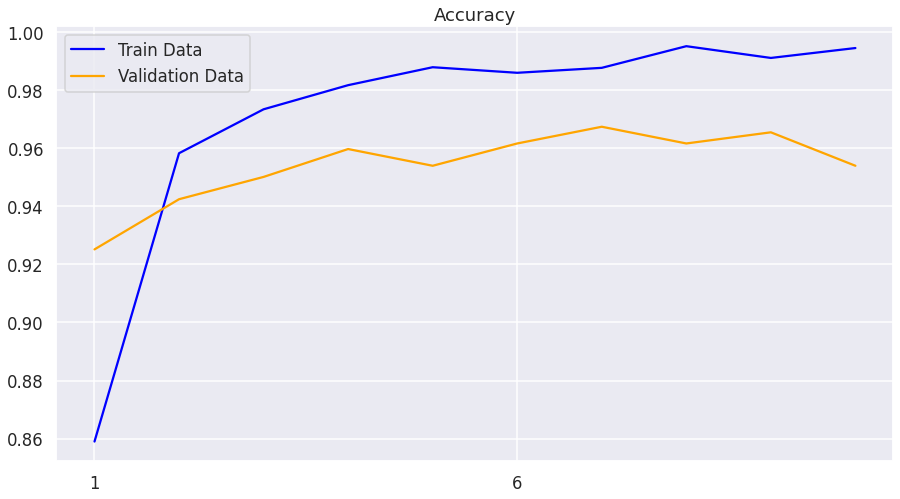

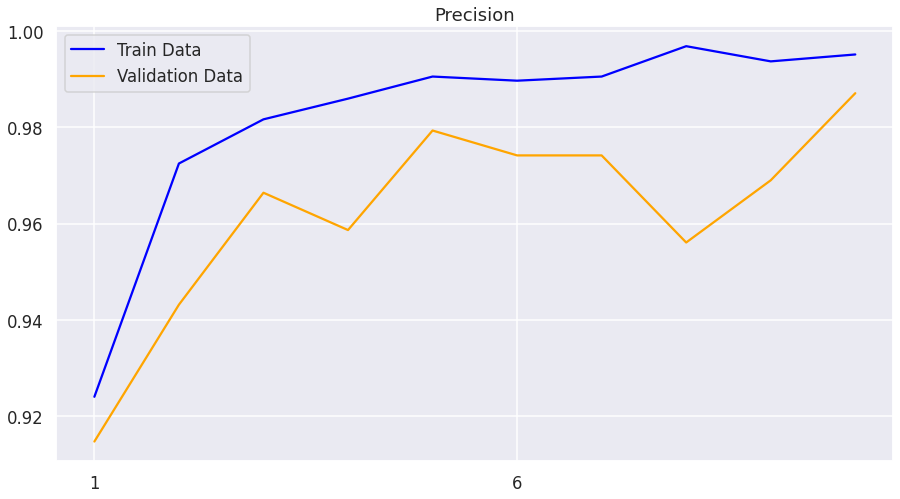

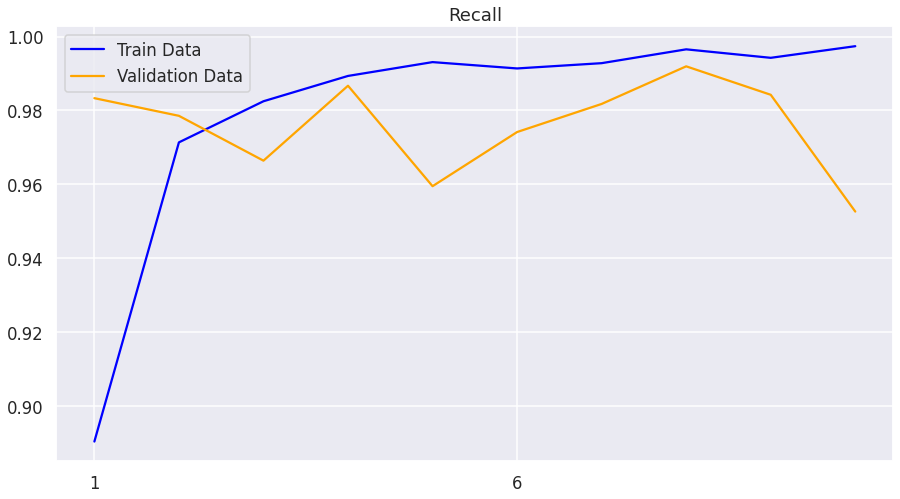

In [ ]:
# evaluate model
model_evaluation(hitory_VGG_5, p_r_iteration=4)

In [ ]:
# evaluate on test set

VGG_5_test_accuracy = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_5_test_precision = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_5_test_recall = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_5_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_5_test_precision*100))
print("Test Set Recall: {}%".format(VGG_5_test_recall*100))

Test Set Accuracy: 69.2307710647583%
Test Set Precision: 67.06896424293518%
Test Set Recall: 99.74358677864075%


In [ ]:
# plot confusion matrix for test set
Y_pred_vgg5 = VGG_5_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg5 = np.where(Y_pred_vgg5 > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg5)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg5))

Confusion Matrix
[[ 43 191]
 [  1 389]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.18      0.31       234
           1       0.67      1.00      0.80       390

    accuracy                           0.69       624
   macro avg       0.82      0.59      0.56       624
weighted avg       0.79      0.69      0.62       624



## Regularize Deeper CNN

In [ ]:
def create_model_VGG_3_dropout(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add final dropout layer
    model.add(Dropout(0.4))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [ ]:
# create model
VGG_3_dropout_model = create_model_VGG_3_dropout()

In [ ]:
# train model
history_VGG_3_dropout = VGG_3_dropout_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=30,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/30
74/74 [==============================] - 50s 672ms/step - loss: 3.8840 - accuracy: 0.7902 - precision_5: 0.8308 - recall_5: 0.9011 - val_loss: 0.2974 - val_accuracy: 0.8637 - val_precision_5: 0.8873 - val_recall_5: 0.9354
Epoch 2/30
74/74 [==============================] - 49s 660ms/step - loss: 0.1999 - accuracy: 0.9208 - precision_5: 0.9434 - recall_5: 0.9504 - val_loss: 0.2336 - val_accuracy: 0.8906 - val_precision_5: 0.9484 - val_recall_5: 0.9018
Epoch 3/30
74/74 [==============================] - 48s 653ms/step - loss: 0.1495 - accuracy: 0.9421 - precision_5: 0.9621 - recall_5: 0.9599 - val_loss: 0.1698 - val_accuracy: 0.9232 - val_precision_5: 0.9677 - val_recall_5: 0.9276
Epoch 4/30
74/74 [==============================] - 48s 655ms/step - loss: 0.1094 - accuracy: 0.9597 - precision_5: 0.9728 - recall_5: 0.9731 - val_loss: 0.1455 - val_accuracy: 0.9443 - val_precision_5: 0.9520 - val_recall_5: 0.9742
Epoch 5/30
74/74 [==============================] - 48s 655ms/step -

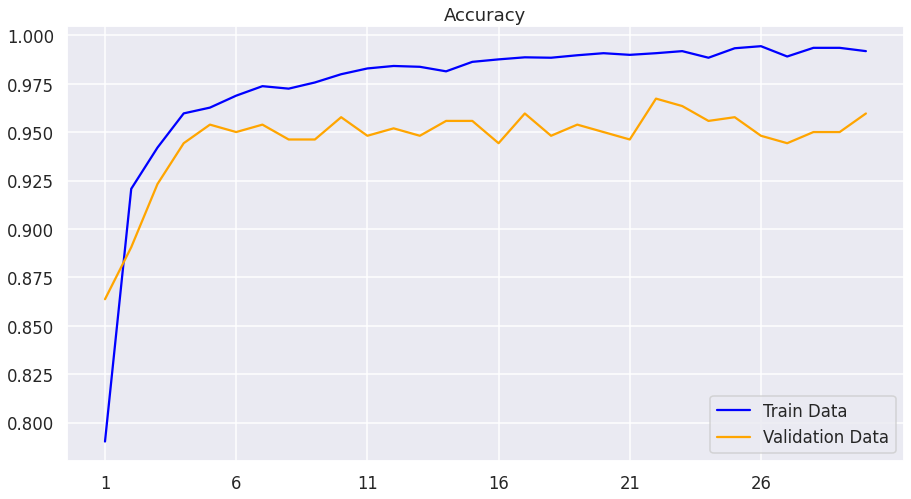

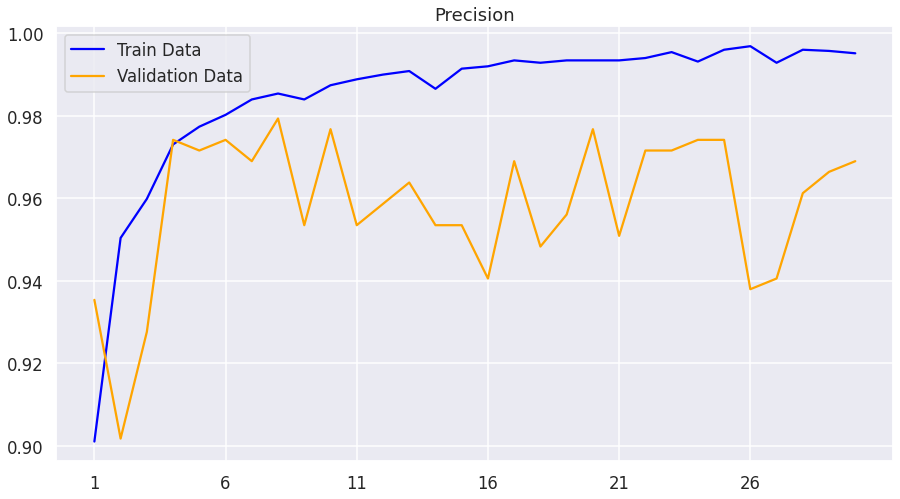

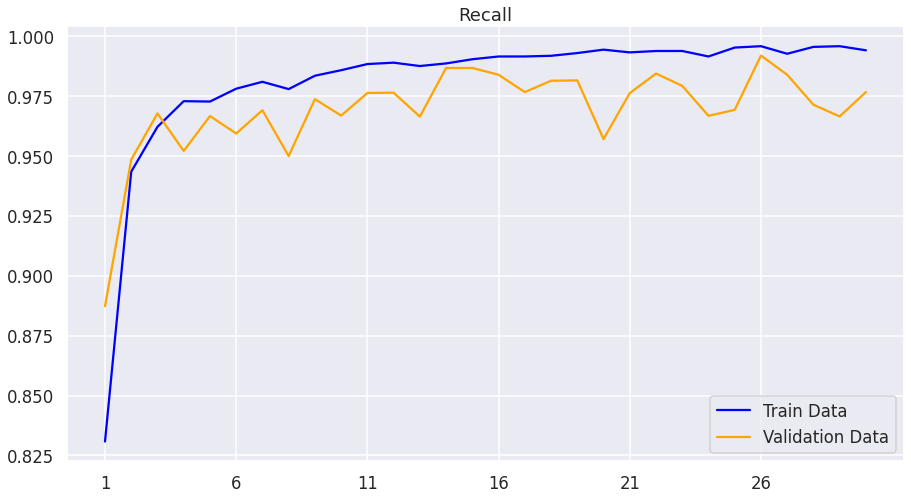

In [ ]:
# evaluate model
model_evaluation(history_VGG_3_dropout, p_r_iteration=5)

In [ ]:
# evaluate on test set

VGG_3_dropout_test_accuracy = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_dropout_test_precision = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_dropout_test_recall = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_dropout_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_dropout_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_dropout_test_recall*100))

Test Set Accuracy: 72.75640964508057%
Test Set Precision: 69.9999988079071%
Test Set Recall: 98.71794581413269%


# Image Data Augmentation

In [ ]:
# create new instance for augmented data
generator_augmented = ImageDataGenerator(rescale=1.0/255.0,
                                         validation_split=0.10,
                                         horizontal_flip=True)
                                         
# Get all the data in the directory chest_xrays/train and resize
train_gen_augmented = generator_augmented.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='training')

# create a validation dataset
val_gen_augmented = generator_augmented.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='validation')

NameError: ignored

In [ ]:
# create augmented model
VGG_3_augmented_model = create_model_VGG_3(classification_threshold=0.50)

In [ ]:
# train model
history_VGG_3_augmented = VGG_3_augmented_model.fit_generator(train_gen_augmented, steps_per_epoch=len(train_gen_augmented), 
                                                                    epochs=30, validation_data=val_gen_augmented, 
                                                                    validation_steps=len(val_gen_augmented))

In [ ]:
# evaluate model
model_evaluation(history_VGG_3_augmented, p_r_iteration=24)

In [ ]:
# evaluate on test set

VGG_3_augmented_test_accuracy = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_augmented_test_precision = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_augmented_test_recall = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_augmented_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_augmented_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_augmented_test_recall*100))

###Adding Batch Normalization Layers

In [ ]:
def create_model_VGG_BN(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add batch norm layer
    model.add(BatchNormalization())

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [ ]:
# create model
VGG_BN_model = create_model_VGG_BN()

In [ ]:
# train model
history_VGG_BN = VGG_BN_model.fit_generator(train_gen_augmented, steps_per_epoch=len(train_gen_augmented), epochs=100,
                              validation_data=test_gen, validation_steps=len(test_gen), callbacks=callbacks)

In [ ]:
# evaluate model
model_evaluation(history_VGG_BN, p_r_iteration=41)

In [ ]:
# evaluate on test set
VGG_BN_test_accuracy = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_BN_test_precision = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_BN_test_recall = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_BN_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_BN_test_precision*100))
print("Test Set Recall: {}%".format(VGG_BN_test_recall*100))

In [ ]:
# plot confusion matrix for test set
Y_pred_vgg5 = VGG_5_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg5 = np.where(Y_pred_vgg5 > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg5)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg5))

After using VGG16 I got very high accuracy which looks like the model is overfitted so will try using simple CNN.




# Different approach

## Exploring our data

#Baseline model

In [ ]:
# evaluate baseline model
model_evaluation(history, p_r_iteration=1)

In [ ]:
results_train = model.evaluate(train_img, train_y)

In [ ]:
results_test = model.evaluate(test_img, test_y)


In [ ]:
# classification report
y_pred = model.predict(test_img)
y_pred = np.rint(y_pred)

print(classification_report(test_y, y_pred, labels=[0,1]))

In [ ]:
# confusion matrix
class_names = ['Normal','Pneumonia']

y_pred = model.predict(test_img)
y_pred = np.rint(y_pred)
    
plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(test_y, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
plt.colorbar()
plt.show()

In [ ]:
visualize_training_results(history)


# Xception 

In [ ]:
#Defining a model distionary for Xception

model_dict = {}
model_name = "Xception"
input_size = (299, 299)
features_dim = [10, 10, 2048]

model_dict['object'] = Xception
model_dict['input_size'] = input_size
model_dict['input_shape'] = input_size + (3, )
model_dict['features_dim'] = features_dim
model_dict['dense_input_dim'] = functools.reduce(operator.mul, features_dim, 1)
model_dict['weights_filename'] = model_name.lower() + '_weights.h5'
model_dict['model_filename'] = 'pneumonia-chest-x-ray-' + model_name.lower() + '.h5'
model_dict['batch_size'] = 128

In [ ]:

# Finding lengths of the data
n_train = train_img.shape[0]
n_test = test_img.shape[0]
n_val = val_img.shape[0]

In [ ]:
# Rescaling 
datagen = ImageDataGenerator(rescale=1. / 255)

# Definig a funstion for feature extraction
def extract_features(model_dict, directory, sample_count):
    
    batch_size = model_dict['batch_size']
    shape = tuple([sample_count] + model_dict['features_dim'])
    features = np.zeros(shape=shape)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=model_dict['input_size'],
        batch_size=batch_size,
        class_mode='binary')
    
    base_model = model_dict['object'](
        input_shape=model_dict['input_shape'],
        weights='imagenet',
        include_top=False)
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size:(i + 1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

# Feature extraction
train_features, train_labels = extract_features(model_dict, train_folder, n_train)
validation_features, validation_labels = extract_features(model_dict, val_folder, n_val)
test_features, test_labels = extract_features(model_dict, test_folder, n_test)